In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [3]:
result = pd.DataFrame()
for i in range(1,4):
    file_name = 'result-%d.csv' % (i)
    read = pd.read_csv(file_name, index_col=0)
    result = pd.concat([result, read], ignore_index=True)
#result[6550:7000]

In [4]:
rgb_out = result.iloc[:,0:8]
#print(rgb_out[0:10])
flow_out = result.iloc[:,8:16]
#print(flow_out[0:5])
labels = result.iloc[:,16]
#print(labels[:5])
#print(rgb_out.shape)

In [5]:
mixed = []
flow_weight = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for weight in range(11):
    mixed.append(np.asarray(rgb_out)*(1-flow_weight[weight]) + np.asarray(flow_out)*flow_weight[weight])
mixed[10][1]

array([ 4.3533006,  6.07057  ,  0.2720636, -3.8268132, -2.4947174,
        9.829166 , -5.4237723, -5.2382607])

In [15]:
sm = []
for weight in range(11):
    tmp = []
    for i in range(mixed[weight].shape[0]):
        tmp.append(softmax(mixed[weight][i]))
    sm.append(np.asarray(tmp))

In [19]:
from sklearn.metrics import accuracy_score
acc = []
for weight in range(11):
    acc.append(accuracy_score(labels, sm[weight].argmax(axis=1)))
print(acc)

[0.9444520830468858, 0.9540079747009487, 0.9620514230716348, 0.966245015811907, 0.9666575003437371, 0.9656262890141619, 0.9651450570603602, 0.963288876667125, 0.9612264540079747, 0.9593702736147395, 0.9575140932215042]


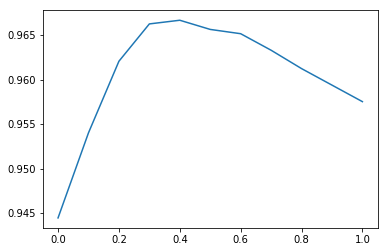

In [24]:
sns.lineplot(flow_weight, acc)

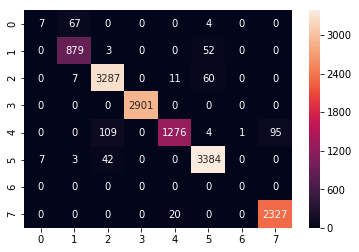

In [29]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(labels, sm[4].argmax(axis=1))
sns.heatmap(cfm, annot=True, fmt='d')